# What to Expect
This notebook wil demo various machine learning and deep learning techniques for text classification problems. Initially, I will explore various datasets before I pick one to deep dive into. The first dataset that I will focus on is scientific paper reviews' data. If the quality of data is good enough, I will carry out sentiment analysis on it using various algorithms. Otherwise I will explore another data set.

# Initial Data Exploration
The main goal of this step is to skim different datasets containing text, examine data quality and finally select the dataset that I will use for demonstrating various machine learning algorithms in action. The main steps will be:


*   Load the dataset into local memory
*   Parse the file into the desired format like a pandas dataframe (this might be a multistep process depending on the level of granularity we need)
*   Examine the basics like the main features, missing values etc
*   If data quality is satisfactory, proceed to machine learning, else move on to exploration of the next dataset






In [ ]:
#Loading the first dataset
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json'

--2020-07-06 18:08:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593600 (580K) [application/x-httpd-php]
Saving to: ‘reviews.json’

reviews.json        100%[===================>] 579.69K  3.20MB/s    in 0.2s    

2020-07-06 18:08:41 (3.20 MB/s) - ‘reviews.json’ saved [593600/593600]



In [12]:
#Importing python libraries
import numpy as np
import pandas as pd #to work with csv files

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#pre-processing of text
import string
import re
import json
import gzip
from urllib.request import urlopen

#import classifiers 
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different evaluation metrics 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function to track the training duration
from time import time

#System libraries
import os
import sys

The json file is nested. Hence, I will visualize all levels (top down approach)

In [ ]:
#Explore dataset (top most level in the nested file)
df = pd.read_json(r'reviews.json')

In [ ]:
df.loc[0,'paper'] #The json file ahs 3 main keys id, preliminary decision and review

{'id': 1,
 'preliminary_decision': 'accept',
 'review': [{'confidence': '4',
   'evaluation': '1',
   'id': 1,
   'lan': 'es',
   'orientation': '0',
   'remarks': '',
   'text': '- El artículo aborda un problema contingente y muy relevante, e incluye tanto un diagnóstico nacional de uso de buenas prácticas como una solución (buenas prácticas concretas). - El lenguaje es adecuado.  - El artículo se siente como la concatenación de tres artículos diferentes: (1) resultados de una encuesta, (2) buenas prácticas de seguridad, (3) incorporación de buenas prácticas. - El orden de las secciones sería mejor si refleja este orden (la versión revisada es #2, #1, #3). - El artículo no tiene validación de ningún tipo, ni siquiera por evaluación de expertos.',
   'timespan': '2010-07-05'},
  {'confidence': '4',
   'evaluation': '1',
   'id': 2,
   'lan': 'es',
   'orientation': '1',
   'remarks': '',
   'text': 'El artículo presenta recomendaciones prácticas para el desarrollo de software seguro. S

In [ ]:
#Extracting the main features of each research paper
paper_df = pd.json_normalize(df["paper"])


In [ ]:
paper_df.head()

,id,preliminary_decision,review
0,1,accept,"[{'confidence': '4', 'evaluation': '1', 'id': ..."
1,2,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
2,3,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
3,4,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
4,5,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."


In [ ]:
#Extracting the main features of review per research paper
review_df = pd.json_normalize(paper_df["review"][0])

In [ ]:
review_df.head()

,confidence,evaluation,id,lan,orientation,remarks,text,timespan
0,4,1,1,es,0,,- El artículo aborda un problema contingente y...,2010-07-05
1,4,1,2,es,1,,El artículo presenta recomendaciones prácticas...,2010-07-05
2,5,1,3,es,1,,- El tema es muy interesante y puede ser de mu...,2010-07-05


In [ ]:
len(df)

101

In [ ]:
#Extracting the main features that I am primarily interested in and combining into final df
final_df =pd.concat([review_df.text, paper_df.preliminary_decision,review_df.confidence], axis=1)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   text                  3 non-null      object
 1   preliminary_decision  172 non-null    object
 2   confidence            3 non-null      object
dtypes: object(3)
memory usage: 4.2+ KB


I am primarily interested in analysing the text data but ~98% data is null values. Hence, I will not proceed with this dataset. Let's look at the next dataset. It is a very large data file which contains millions of Amazon product reviews. I will be analysing the first 1 million reviews.

In [3]:
#Loading the second dataset
!wget http://snap.stanford.edu/data/amazon/productGraph/item_dedup.json.gz

--2020-07-09 15:15:15--  http://snap.stanford.edu/data/amazon/productGraph/item_dedup.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19233006068 (18G) [application/x-gzip]
Saving to: ‘item_dedup.json.gz’

item_dedup.json.gz  100%[===================>]  17.91G  12.5MB/s    in 48m 47s 

2020-07-09 16:04:02 (6.27 MB/s) - ‘item_dedup.json.gz’ saved [19233006068/19233006068]



In [4]:
f = gzip.open('item_dedup.json.gz')


In [8]:
#Since, the file size is very big, parsing the entire file crashes the session. 
# I will unwrap first million records

i = 0
data = []
for line in f:
  i+=1
  data.append(json.loads(line))
  if i>1000000:
    break

f.close()
  
df = pd.DataFrame(data)

In [10]:
df.isnull().sum()

reviewerID            0
asin                  0
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
reviewerName      59931
dtype: int64

I want to analyse text- hence, I am interested in the reviewText feature. It has 0 null values. That's great! So I will finalise this dataset.

The text classification throughout this notebook will be sentiment analysis. We can see the review and star rating for each product. I will add one more feature (the output class) called 'Sentiment'. If the rating is 3, the sentiment is 'OK', if it >3 the sentiment is 'Positive' else it is 'Negative'

In [13]:
df['sentiment'] = pd.Series(df['overall'].apply(lambda x: 0 if x == 3 else(1 if x > 3 else -1) ))

In [14]:
df.head()

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,reviewerName,sentiment
0,A3AF8FFZAZYNE5,0000000078,"[1, 1]",Conversations with God Book 1 is the single mo...,5.0,Impactful!,1092182400,"08 11, 2004",NaN,1
1,AH2L9G3DQHHAJ,0000000116,"[5, 5]",Interesting Grisham tale of a lawyer that take...,4.0,Show me the money!,1019865600,"04 27, 2002",chris,1
2,A2IIIDRK3PRRZY,0000000116,"[0, 0]",The thumbnail is a shirt. The product shown i...,1.0,Listing is all screwed up,1395619200,"03 24, 2014",Helene,-1
3,A1TADCM7YWPQ8M,0000000868,"[10, 10]",I'll be honest. I work for a large online reta...,4.0,Not a Bad Translation,1031702400,"09 11, 2002",Joel@AWS,1
4,AWGH7V0BDOJKB,0000013714,"[0, 0]",It had all the songs I wanted but I had ordere...,4.0,Not the large print,1383177600,"10 31, 2013",Barbara Marshall,1


# Shallow Machine Learning for Text Classification

### Naive Bayes

In [17]:
#Function to clean data (remove stopwords, punctuation and numbers)
stopwords = stop_words.ENGLISH_STOP_WORDS
def clean(doc): #doc is a string of text
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    return doc

In [15]:
from sklearn.model_selection import train_test_split

#Saving data into x and y variables
X = df.reviewText
y = df.sentiment
print('shape of X: ', X.shape)
print('shape of y: ',y.shape)

#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print('shape of X_train: ', X_train.shape)
print('shape of y_train: ',y_train.shape)
print('shape of X_test: ', X_test.shape)
print('shape of y_test: ',y_test.shape)

shape of X:  (1000001,)
shape of y:  (1000001,)
shape of X_train:  (750000,)
shape of y_train:  (750000,)
shape of X_test:  (250001,)
shape of y_test:  (250001,)


In [18]:
#Preprocess train and test data (vectorization)
vect = CountVectorizer(preprocessor=clean) 
X_train_dtm = vect.fit_transform(X_train)
#transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)


(750000, 1095433) (250001, 1095433)


In [19]:
#Train the Naive Bayes Classifier
nb = MultinomialNB() #instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)


CPU times: user 883 ms, sys: 19.8 ms, total: 903 ms
Wall time: 910 ms


Accuracy:  0.8355086579653681


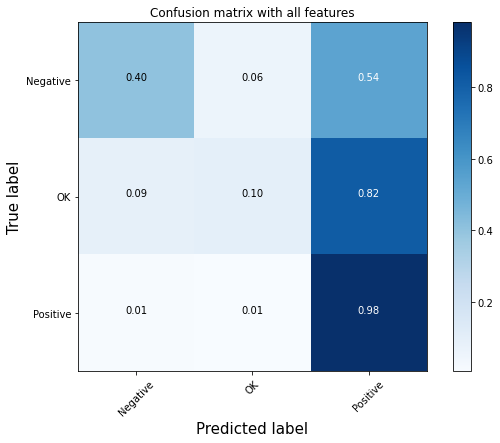

In [28]:
#Evaluate the model and visualize the results in a confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    
#Print accuracy:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative','OK','Positive'],normalize=True,
                      title='Confusion matrix with all features')

y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]



### Support Vector Machines

In [ ]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) 
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') 
classifier.fit(X_train_dtm, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

#calculate evaluation measures:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("AUC: ", metrics.roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative','OK','Positive'],normalize=True,
                      title='Confusion matrix with normalization')